In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
import glob
from matplotlib import pyplot as plt
%matplotlib inline
!pip install nilearn
import nilearn

In [0]:
filenames = sorted(glob.glob('drive/My Drive/Research/Augmented Dataset/Aug_Inputs_Normalized_npz/*'))
labels = sorted(glob.glob('drive/My Drive/Research/Augmented Dataset/Aug_Labels_Normalized_npz/*'))

# len(labels)

In [0]:
from sklearn.model_selection import train_test_split

filenames = sorted(glob.glob('drive/My Drive/Research/Augmented Dataset/Aug_Inputs_Normalized_npz/*'))
labels = sorted(glob.glob('drive/My Drive/Research/Augmented Dataset/Aug_Labels_Normalized_npz/*'))

from sklearn.utils import shuffle

filenames , labels = shuffle(filenames, labels)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames, labels, test_size=0.2, random_state=1)

print("Training Set Size: ", len(X_train_filenames), " MRIs")
print("Validation Set Size: ", len(X_val_filenames), " MRIs")


Training Set Size:  1279  MRIs
Validation Set Size:  320  MRIs


In [0]:
temp1 = np.load(filenames[0])['arr_0']
temp2 = np.load(filenames[1])['arr_0']

temp = np.concatenate((temp1,temp2))
print(temp.shape)

(520, 64, 64, 1)


In [0]:
import keras
import cv2
class My_Custom_Generator(keras.utils.Sequence) :  
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    N = 64 
    images = np.load(batch_x[0])['arr_0']
    for f in range(1,len(batch_x)):
      temp = np.load(batch_x[f])['arr_0']
      images = np.concatenate((images,temp))

    # maximum = np.max(images)    
    # minimum = np.min(images)
    # images = (images - minimum) / (maximum - minimum)

    labels = np.load(batch_x[0])['arr_0']
    for f in range(1,len(batch_y)):
      temp = np.load(batch_y[f])['arr_0']
      labels = np.concatenate((labels,temp))

    # m = np.max(labels) 
    # mi = np.min(labels)
    # labels = (labels - mi) / (m - mi)

    for i in range(len(labels)):
      for j in range(N):
        for k in range(N):
          if (images[i,j,k,0] == 0): #images array contains data from skull striped images; 
            labels[i,j,k,0] = 0 #this is done to set those pixel values that are outside the brain in the images ground truth to 0

    return images, labels


Using TensorFlow backend.


In [0]:
# inst = My_Custom_Generator(X_train_filenames, y_train, 32)
# img, lab = inst.__getitem__(1)

# print(np.shape(img),np.shape(lab))

In [0]:
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
#from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras.losses import mean_absolute_error,mean_squared_error
from keras import regularizers
from keras import backend as K

In [0]:
# batch_size = 256
# epochs = 100
inChannel = 1
N=64
x, y = N, N
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
  
    #encoder
    
    conv1 = Conv2D(12, (7, 7), activation='relu', padding='same')(input_img) # N x N x 12
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(12, (7, 7), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32

    conv2 = Conv2D(24, (7, 7), activation='relu', padding='same')(pool1) # N/2 x N/2 x 24
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(24, (7, 7), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #14 x 14 x 32
    
    conv3 = Conv2D(48, (7, 7), activation='relu', padding='same')(pool2) # N/4 x N/4 x 24
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(48, (7, 7), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3) 

    #decoder

    conv4 = Conv2D(48, (7, 7), activation='relu', padding='same')(conv3) # N/2 x N/2 x 24
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(48, (7, 7), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4) 
    
    up1 = UpSampling2D((2,2))(conv4) 

    conv5 = Conv2D(24, (7, 7), activation='relu', padding='same')(up1) # N/2 x N/2 x 24
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(24, (7, 7), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up2 = UpSampling2D((2,2))(conv5) 
    
    conv6 = Conv2D(12, (7, 7), activation='relu', padding='same')(up2) # N x N x 12
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(12, (7, 7), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(conv6) # N x N x 1
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop()) #a better metric (instead of mean squared error) to verify the performance would be 
autoencoder.summary()                                                 #to feed the corrected MRI images in Brainsuite and find out if the segmentation of the brain 
                                                                      #tissues is done right

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 12)        600       
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 12)        48        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 12)        7068      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 12)        48        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 24)        1413

In [0]:
batch_size = 8

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, 8)


## Define our model here.


autoencoder_train = autoencoder.fit_generator(generator = my_training_batch_generator,
                   steps_per_epoch =  int(len(X_train_filenames) // batch_size),
                   epochs = 10,
                   verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(len(X_val_filenames) // 8))

Epoch 1/10
159/159 [==============================] - 888s 6s/step - loss: 0.0326 - val_loss: 0.0921
Epoch 2/10
159/159 [==============================] - 909s 6s/step - loss: 0.0321 - val_loss: 0.1482
Epoch 3/10
159/159 [==============================] - 903s 6s/step - loss: 0.0319 - val_loss: 0.1315
Epoch 4/10
159/159 [==============================] - 895s 6s/step - loss: 0.0319 - val_loss: 0.0807
Epoch 5/10
159/159 [==============================] - 887s 6s/step - loss: 0.0318 - val_loss: 0.1440
Epoch 6/10
159/159 [==============================] - 894s 6s/step - loss: 0.0318 - val_loss: 0.2248
Epoch 7/10
159/159 [==============================] - 889s 6s/step - loss: 0.0318 - val_loss: 0.1004
Epoch 8/10
159/159 [==============================] - 893s 6s/step - loss: 0.0317 - val_loss: 0.2184
Epoch 9/10
159/159 [==============================] - 902s 6s/step - loss: 0.0317 - val_loss: 0.2078
Epoch 10/10
159/159 [==============================] - 908s 6s/step - loss: 0.0318 - val_lo

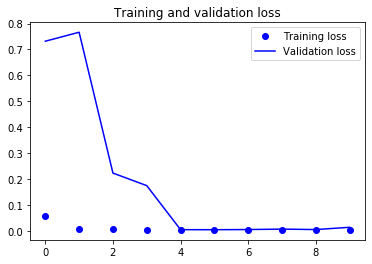

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
# pred = autoencoder.predict(valid_X)
autoencoder.save('drive/My Drive/Research/Models/autoencoder_Augmented_model.h5') #to save the weights of the trained model

Ground truth for the Test Images


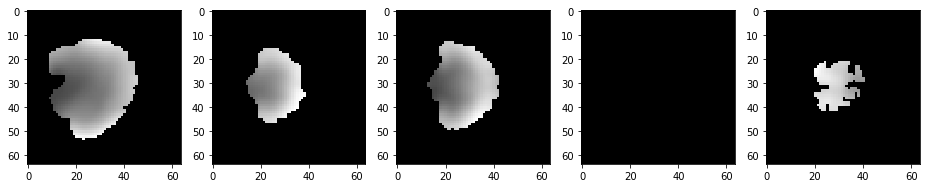

In [0]:
plt.figure(figsize=(16, 4))
print("Ground truth for the Test Images")
#Displaying the first five images from the ground truth of the test images

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i+200,:,:,0],cmap='gray')                                               #plt.imshow(valid_ground[i+200, ..., 205], cmap='gray')
plt.show()    

Reconstruction of Bias field from the Test Images


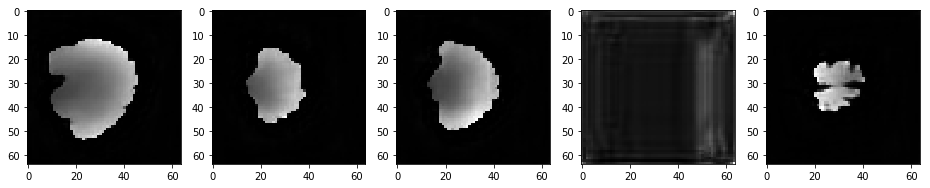

In [0]:
plt.figure(figsize=(16, 4))
print("Reconstruction of Bias field from the training dataset")
#Displaying the first five images from the prediction made by the auto encoder on the test images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i+200,:,:,0],cmap='gray')                                                                                           #plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [0]:
autoencoder.save('drive/My Drive/autoencoder_model.h5') #to save the weights of the trained model